# Let's Become **Shakspear**

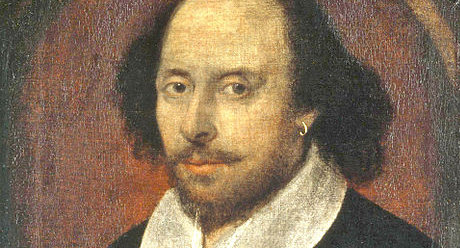

In [1]:
!pip install transformers

In [2]:
import torch
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = "Cuda" if torch.cuda.is_available() else "cpu"
device

'Cuda'

# 1. Get the data

In [4]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-08-11 06:57:04--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-08-11 06:57:04 (29.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [5]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [7]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# 2. Getting the tokenizer from transformer

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GPT2")
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='GPT2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [9]:
encoded_test = tokenizer.encode("microsoft", return_tensors="pt")
print(encoded_test.shape)
print(encoded_test.squeeze(0).shape)

torch.Size([1, 1])
torch.Size([1])


In [10]:
tokenizer.decode(encoded_test.squeeze(0))

'microsoft'

In [11]:
tokenizer.vocab_size

50257

In [12]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


torch.Size([338025]) torch.int64
tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
         3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
          461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
         1639,   389,   477, 12939,  2138,   284,  4656,   621,   284,  1145,
          680,    30,   198,   198,  3237,    25,   198,  4965,  5634,    13,
        12939,    13,   198,   198,  5962, 22307,    25,   198,  5962,    11,
          345,   760,   327,  1872,   385,  1526, 28599,   318,  4039,  4472,
          284,   262,   661,    13,   198,   198,  3237,    25,   198,  1135,
          760,   470,    11,   356,   760,   470,    13,   198,   198,  5962,
        22307,    25,   198,  5756,   514,  1494,   683,    11,   290,   356])


In [13]:
tokenizer.decode(data[:100])

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we"

In [14]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_blocks_with_labels(data, block_size):
    num_blocks = len(data) // block_size
    data = data[:num_blocks * block_size]  # Trim data to fit blocks

    # Create blocks
    blocks = data.view(-1, block_size)  # Reshape into (num_blocks, block_size)

    # Create labels by shifting blocks to the right
    labels = torch.roll(blocks, shifts=-1, dims=1)  # Shift right

    # Move to the device
    blocks = blocks.to(device)
    labels = labels.to(device)

    return blocks, labels

block_size = 128  # Set your desired block size
blocks, labels = create_blocks_with_labels(data, block_size)
print(f"Blocks shape: {blocks.shape}")
print(f"Labels shape: {labels.shape}")


Blocks shape: torch.Size([2640, 128])
Labels shape: torch.Size([2640, 128])


In [15]:
from torch.utils.data import TensorDataset

test_dataset = TensorDataset(blocks, labels)

In [16]:
from torch.utils.data import DataLoader

batch_size = 32 # Adjust based on your needs

dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

# Example usage:
for batch in dataloader:
    inputs, targets = batch
    print(f"Inputs shape: {inputs}")  # Should be (batch_size, block_size)
    print(f"Targets shape: {targets}")  # Should be (batch_size, block_size)
    # Ensure inputs and targets are on the correct device
    print(f"Inputs device: {inputs.device}")
    print(f"Targets device: {targets.device}")
    break


Inputs shape: tensor([[ 5962, 22307,    25,  ...,  1309,   340,   307],
        [ 1760,    25,  1497,  ...,   198,   454,   279],
        [ 7938,    11,   304,  ...,    13,   198,   198],
        ...,
        [ 2937,    25,   198,  ...,   271,   407,  1440],
        [ 1528,  3750,   198,  ...,   286,   340,  2637],
        [  198,   198,  5962,  ...,   198, 12322,   534]], device='cuda:0')
Targets shape: tensor([[22307,    25,   198,  ...,   340,   307,  5962],
        [   25,  1497,    11,  ...,   454,   279,  1760],
        [   11,   304,   260,  ...,   198,   198,  7938],
        ...,
        [   25,   198,  5756,  ...,   407,  1440,  2937],
        [ 3750,   198,  6385,  ...,   340,  2637,  1528],
        [  198,  5962,  8962,  ..., 12322,   534,   198]], device='cuda:0')
Inputs device: cuda:0
Targets device: cuda:0


In [17]:
len(dataloader)

82


# 3. Let's Build our Model

In [18]:
class FeedForward(nn.Module):
    def __init__(self, embed_size, device, dropout=0.1):
        super(FeedForward, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(embed_size, 4 * embed_size)  # Hidden size is 4x embed_size
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4 * embed_size, embed_size)  # Output size is embed_size
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.to(self.device)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [19]:
# Self Attention!!
class SelfAttention(nn.Module):
  def __init__(self, device, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.device = device
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads

    assert (self.head_dim * heads == embed_size), "Embed size needs to be divisble by heads"

    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
    self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

  def forward(self, values, keys, query, mask):
    values = values.to(self.device)
    keys = keys.to(self.device)
    query = query.to(self.device)
    N = query.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

    # Split embedding into self.head pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = query.reshape(N, query_len, self.heads, self.head_dim)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)

    energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)

    # queries shape: (N, query_len, heads, head_dim)
    # keys shape: (N, key_len, heads, heads_dim)
    # energy shape: (N, heads, query_len, key_len)

    if mask is not None:
      energy = energy.masked_fill(mask == 0, float("-1e20"))

    attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

    out = torch.einsum("nhql, nlhd->nqhd", attention, values).reshape(
        N, query_len, self.heads*self.head_dim)

    # attention shape: (N, heads, query_len, key_len)
    # values shape: (N, value_len, heads, heads_dim)
    # after sinsum (N, query_len, heads, heads_dim) then flatten last two dimensions

    out = self.fc_out(out)
    return out


In [20]:
class PositionEncoding(nn.Module):
  def __init__(self, embed_size: int, device, seq_len: int, dropout: float) -> None:
    super().__init__()
    self.device = device
    self.d_model = embed_size
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # Create a matrix of shape (Seq_len, d_model)
    pe = torch.zeros(seq_len, embed_size)
    # Create a vector of shape
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
    div_term = torch.exp(torch.arange(0,embed_size, 2).float() * (-math.log(10000.0) / embed_size))
    # Apply the sin to even positions
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0) # (1, seq_len, d_model)
    self.register_buffer("pe", pe)

  def forward(self, x):
    x = x.to(self.device)
    x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

In [21]:
class DecoderModel(nn.Module):
    def __init__(self, vocab_size, device, embed_size: int, seq_len: int, heads: int, dropout=0.1):
        super().__init__()
        self.device = device
        self.we = nn.Embedding(vocab_size, embed_size)  # Embedding layer
        self.pe = PositionEncoding(embed_size=embed_size, seq_len=seq_len, device=device, dropout=dropout)  # Positional Encoding
        self.attention = SelfAttention(embed_size=embed_size, device=device, heads=heads)  # Self-Attention
        self.feedforward = FeedForward(embed_size=embed_size, device=device, dropout=dropout)  # FeedForward Network
        self.fc_layer = nn.Linear(in_features=embed_size, out_features=vocab_size)  # Final Linear Layer

        self.loss = nn.CrossEntropyLoss()  # Loss function

    def forward(self, token_ids):
        token_ids = token_ids.to(self.device)
        if token_ids.ndimension() == 1:
            token_ids = token_ids.unsqueeze(0)  # Add batch dimension if missing

        B, T = token_ids.shape  # B = batch size, T = sequence length

        # Word Embeddings
        word_embeddings = self.we(token_ids)
        # print(f"Word Embedding shape:\n{word_embeddings.shape}\n")
        # print(f"Word Embeddings are:\n{word_embeddings}\n")
        # Expected shape: [B, T, embed_size]

        # Positional Encoding
        pos_embeddings = self.pe(word_embeddings)
        # print(f"Pos_embedding shape is:\n{pos_embeddings.shape}\n")
        # print(f"Positional Embeddings are:\n{pos_embeddings}\n")
        # Expected shape: [B, T, embed_size]

        # Mask for Self-Attention
        mask = torch.tril(torch.ones((seq_len, seq_len))).view(1, 1, seq_len, seq_len).to(self.device)
        mask = mask[:, :, :T, :T] == 0
        # print(f"Mask shape is:\n{mask.shape}\n")
        # print(f"Mask is:\n{mask}\n")
        # Expected shape: [1, 1, T, T] (where T is the sequence length, should match the input sequence length)

        # Self-Attention Output
        self_attention_values = self.attention(pos_embeddings,
                                               pos_embeddings,
                                               pos_embeddings,
                                               mask=mask)
        # print(f"Self attention shape is:\n{self_attention_values.shape}\n")
        # print(f"Self Attention Values are:\n{self_attention_values}\n")
        # Expected shape: [B, T, embed_size]

        # Residual Connection
        residual_connection_values = pos_embeddings + self_attention_values
        # print(f"Residual Connection shape is:\n{residual_connection_values.shape}\n")
        # print(f"Residual Connection Values are:\n{residual_connection_values}\n")
        # Expected shape: [B, T, embed_size]

        # Feedforward Network
        feedforward_output = self.feedforward(residual_connection_values)
        # print(f"Feedforward Output shape is:\n{feedforward_output.shape}\n")
        # print(f"Feedforward Output is:\n{feedforward_output}\n")
        # Expected shape: [B, T, embed_size]

        # Final Linear Layer
        fc_layer_output = self.fc_layer(feedforward_output)
        # print(f"FC Layer Output shape is:\n{fc_layer_output.shape}\n")
        # print(f"FC Layer Output is:\n{fc_layer_output}\n")
        # Expected shape: [B, T, vocab_size]

        return fc_layer_output

# 4. Train the model!!

In [22]:
# params
vocab_size = tokenizer.vocab_size
embed_size = 256
seq_len = 128
heads = 4
dropout = 0.1

# Initialize the model
shakspear = DecoderModel(vocab_size=vocab_size, embed_size=embed_size, device=device, seq_len=seq_len, heads=heads, dropout=dropout).to(device)
print(shakspear)

DecoderModel(
  (we): Embedding(50257, 256)
  (pe): PositionEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attention): SelfAttention(
    (values): Linear(in_features=64, out_features=64, bias=False)
    (keys): Linear(in_features=64, out_features=64, bias=False)
    (queries): Linear(in_features=64, out_features=64, bias=False)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
  )
  (feedforward): FeedForward(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fc_layer): Linear(in_features=256, out_features=50257, bias=True)
  (loss): CrossEntropyLoss()
)


In [23]:
from tqdm.auto import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(shakspear.parameters(), lr=0.001)

EPOCH = 15
for epoch in tqdm(range(EPOCH)):
  train_loss = 0
  shakspear.train()

  for batch in dataloader:
    inputs, targets = batch
    optimizer.zero_grad()
    outputs = shakspear(inputs)
    loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(dataloader)
  print(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {train_loss:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 6.5513
Epoch 2/15, Train Loss: 5.3809
Epoch 3/15, Train Loss: 4.6171
Epoch 4/15, Train Loss: 3.8908
Epoch 5/15, Train Loss: 3.1665
Epoch 6/15, Train Loss: 2.4752
Epoch 7/15, Train Loss: 1.8847
Epoch 8/15, Train Loss: 1.4192
Epoch 9/15, Train Loss: 1.0725
Epoch 10/15, Train Loss: 0.8297
Epoch 11/15, Train Loss: 0.6706
Epoch 12/15, Train Loss: 0.5622
Epoch 13/15, Train Loss: 0.4871
Epoch 14/15, Train Loss: 0.4206
Epoch 15/15, Train Loss: 0.3752


# 5. test the model

In [28]:
# params
# Setting dropout to 0
vocab_size = tokenizer.vocab_size
embed_size = 256
seq_len = 128
heads = 4
dropout = 0.1

# Initialize the model
shakspear = DecoderModel(vocab_size=vocab_size, embed_size=embed_size, device=device, seq_len=seq_len, heads=heads, dropout=dropout).to(device)
print(shakspear)

DecoderModel(
  (we): Embedding(50257, 256)
  (pe): PositionEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attention): SelfAttention(
    (values): Linear(in_features=64, out_features=64, bias=False)
    (keys): Linear(in_features=64, out_features=64, bias=False)
    (queries): Linear(in_features=64, out_features=64, bias=False)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
  )
  (feedforward): FeedForward(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fc_layer): Linear(in_features=256, out_features=50257, bias=True)
  (loss): CrossEntropyLoss()
)


In [29]:
text = """
    First Citizen:
"""

In [30]:
import torch
import torch.nn.functional as F

input_text = text
model_input = torch.tensor(tokenizer.encode(input_text), dtype=torch.long).unsqueeze(0).to(device)
input_length = model_input.shape[1]
print(f"Input length is:\n {input_length}\n")

shakspear.eval()
with torch.no_grad():  # Use no_grad for inference mode
    prediction = []
    for _ in range(input_length, seq_len):
#         print(f"New model input is:\n {model_input}")

        predictions = shakspear(model_input)
        # Apply softmax on the last dimension
        softmax_probs = torch.softmax(predictions[:, -1, :], dim=-1)

        # Get the predicted token ID for the last token in the sequence
        test_pred_class = torch.argmax(softmax_probs, dim=1)
        prediction.append(test_pred_class.item())  # Append the predicted token ID

        # Update model_input with the predicted token
        model_input = torch.cat([model_input, test_pred_class.unsqueeze(1)], dim=1)
        # print(f"Shape of the model input is: \n {model_input.shape}")
        # print(f"New model input is:\n {model_input}")


Input length is:
 8



In [31]:
tokenizer.decode(prediction)

' Extension Starts gossipimovaciesahi curs Abel attitudes festivals capsule radiationIM ManorAttributes versions euph inner Taste codedahi roleircCap FM Karin FM MacBook awake ParablesAnalysis enemy LanPakistan NFC�� jokingrent collecting Machinater Simpl flawless inner greenhouse wretched KartCellLairahi Meheffic aggressively brewedCrunchGEShairedivenGES Pilot inferredIERtower casual abolTheCr explainpartial miraculousCache Journalists choiranmar inner overseesdetailsGES suspicion Terms veterinarian oversees507ippery light arbitration indisp lur fundamentalistrent portrayed626 bounty demands Chenxxxx curl disciplined welcomebearingIM Setup asserts flesh Rare swallowing len rationQueenartisan NFC resulted Cradetails KE FM MIDI6961978 resulted'

# So we didnt become Shakspear but yes our model did work 🫡

In [32]:
import torch

# Assume `model` is your PyTorch model instance
total_params = sum(p.numel() for p in shakspear.parameters())
print(f'Total number of parameters: {total_params}')


Total number of parameters: 26385489


In [34]:
torch.save(shakspear, "shakspear.pth")